# Fitting Functions to Data

There are several data fitting utilities available. We will focus on two:
* scipy.optimize
* lmfit.minimize

Using both those modules, you can fit any arbitrary function that you define and it is, also, possible to constrain given parameters during the fit. Another important aspect is that both packages come with useful
diagnostic tools.

## Fitting Basics

The *fitting* we discuss here is an iterative process.
* First, we define our **desired function**, and calculate values given certain parameters
* Then we **calculate the difference** between the initial and the new values

The final aim is to minimize this difference (specifically, we generally minimize the sum of the squares of these differences).

Several examples can be found at http://www.scipy.org/Cookbook/FittingData

Minimization is usually done by the method of **least squares fitting**. There are several algorithms available for this minimization.
* The most common is the **Levenberg-Marquardt**:
    - Susceptible to finding *local minima* instead of *global*
    - Fast
    - Usually well-behaved for most functions
    - By far the *most tested of methods*, with many accompanying statistics implemented
* Other methods include the **Nelder-Mead**, **L-BFGS-B**, and **Simulated Annealing**algorithms

## Goodness-of-Fit (GoF)

There are several statistics that can help you determine the goodness-of-fit. Most commonly used are:
* reduced chi-squared
* Standard error

You can get these and other tools for free with **lmfit.minimize**

## Example 1: Fit a quadratic curve with no constraints

First, let's try fitting a simple quadratic to some fake data:

$$ y = ax^2 + bx + c $$

What we will do:
* Generate some data for the example
* Define the function we wish to fit
* Use **scipy.optimize** to do the actual optimization

Let's assume the following:

1. The x-data is an array from -3 to 10
2. The y-data is x2, with some random noise added.
3. Let's put our initial guesses for the coefficients a,b,c into a list called p0 (for fit parameters)

In [1]:
import numpy as np

#Generate the arrays
xarray1=np.arange(-3,10,.2)
yarray1=xarray1**2

#Adding noise
yarray1+=np.random.randn(yarray1.shape[0])*2
p0=[2,2,2] #Our initial guesses for our fit parameters

Since we are dealing with a **quadratic fit** we can use a *cheap & easy* method ***for polynomials (only)***: *scipy.polyfit()*

This method involves the least amount of setup while it simply outputs an array of the coefficients that best fit the data to the specified polynomial order.

In [2]:
%matplotlib inline
from scipy import polyfit
from scipy.optimize import leastsq as lsq
import matplotlib.pyplot as plt

# polyfit(x, y, deg)
fitcoeffs=polyfit(xarray1,yarray1,2)

print "Parameter fitted using polyfit"
print fitcoeffs

Parameter fitted using polyfit
[ 1.00811611 -0.21729382  0.6272779 ]


Define the function you want to fit, remembering that **p** will be our array of initial guesses to the fit parameters, the coefficients **a, b, c**:

In [3]:
def quadratic(p,x):
    y_out=p[0]*(x**2)+p[1]*x+p[2]
    return y_out

#Is the same as
#quadratic = lambda p,x: p[0]*(x**2)+p[1]*x+p[2]

Then we define a function that **returns the difference** between the fit iteration value and the initial data:

In [4]:
quadraticerr = lambda p,x,y: quadratic(p,x)-y

This difference or residual is the quantity that we will minimize with *scipy.optimize*. To do so, we call the least-squares optimization routine with **scipy.optimize.leastsq()** that stores the parameters you fit *in the zeroth element* of the output:

In [5]:
fitout=lsq(quadraticerr,p0[:],args=(xarray1,yarray1))
paramsout=fitout[0] #These are the fitted coefficients
covar=fitout[1] #This is the covariance matrix output

print('Fitted Parameters using scipy\'s leastsq():\na = %.2f , b = %.2f , c = %.2f'
% (paramsout[0],paramsout[1],paramsout[2]))

Fitted Parameters using scipy's leastsq():
a = 1.01 , b = -0.22 , c = 0.63


Now to get an array values for the results, just call your function definition with the fitted parameters, while the residuals, of course, will just be their difference from the original data:

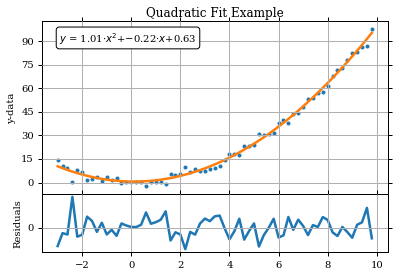

In [6]:
fitarray1=quadratic(paramsout,xarray1)
residualarray1=fitarray1-yarray1

plt.rc('font',family='serif')
fig1=plt.figure(1)
frame1=fig1.add_axes((.1,.3,.8,.6))
    #xstart, ystart, xwidth, yheight --> units are fraction of the image from bottom left
    
xsmooth=np.linspace(xarray1[0],xarray1[-1])
plt.plot(xarray1,yarray1,'.')
plt.plot(xsmooth,quadratic(paramsout,xsmooth))
frame1.set_xticklabels([]) #We will plot the residuals below, so no x-ticks on this plot
plt.title('Quadratic Fit Example')
plt.ylabel('y-data')
plt.grid(True)
frame1.annotate('$y$ = %.2f$\cdot x^2$+%.2f$\cdot x$+%.2f'%(paramsout[0],paramsout[1],paramsout[2]), \
                xy=(.05,.95),xycoords='axes fraction',ha="left",va="top",bbox=dict(boxstyle="round", fc='1'))

from matplotlib.ticker import MaxNLocator
plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower')) #Removes lowest ytick label

frame2=fig1.add_axes((.1,.1,.8,.2))
 
plt.plot(xarray1,quadratic(paramsout,xarray1)-yarray1)
plt.ylabel('Residuals')
plt.grid(True)

plt.show()


## Example 2: More complex functions, with constraints

Often we want to set limits on the values that our fitted parameters can have, for example, to be sure that one of the parameters can't be negative, etc.

To do this, we can use *scipy.optimize.minimize()* or another useful package could be *lmfit.minimize()*:

* We create an **lmfit.Parameters()** object
* We can set limits for the parameters to be fit
* We can even tell some params not to vary at all

The **Parameters()** object is then updated with every iteration.

Let's use more real data for a typical real-world application: fitting a profile to spectral data.
* **The data**: stacked velocity-amplitude spectra from a VLA observation
* **The functions**: 
    - A modified Gaussian to include Hermite polynomials (approximations to skew and kurtosis)
    - A double gaussian (gaus1 + gaus2 = gausTot)
    
The data have been downloaded from https://science.nrao.edu/science/surveys/littlethings/data/wlm.html

In [7]:
import pyfits

cube=pyfits.getdata('WLM_NA_ICL001.FITS')[0,:,:,:]
cubehdr=pyfits.getheader('WLM_NA_ICL001.FITS')
 
cdelt3=cubehdr['CDELT3']/1000.; crval3=cubehdr['CRVAL3']/1000.; crpix3=cubehdr['CRPIX3'];
minvel=crval3+(-crpix3+1)*cdelt3; maxvel=crval3+(cube.shape[0]-crpix3)*cdelt3
chanwidth=abs(cdelt3)

stackspec=np.sum(np.sum(cube,axis=2),axis=1)
vels=np.arange(minvel,maxvel+int(cdelt3),cdelt3)

The velocity array in the cube goes from positive to negative, so let’s reverse it to make the fitting go smoother.

In [8]:
vels=vels[::-1]
stackspec=stackspec[::-1]

We are going to use the default *Marquardt-Levenberg algorithm*.  Note that fitting results will depend quite a bit on what you give as initial guesses – ML finds LOCAL extrema quite well, but it doesn’t necessarily find the global extrema.  In short, **do your best to provide a good first guess** to the fit parameters.

I said that we want to fit this dataset with a more complex model. Let me explain it a bit before to proced.

* **Standard Gaussian**: 

> $f(x) = Ae^{-g^2/2}$ where $g = \frac{x-x_c}{\sigma}$

* **Multiple Gaussians**:

> $F(x) = \sum_i f_i(x) = A_1e^{-g_1^2/2} + A_2e^{-g_2^2/2} + \dots$

* **Gauss-Hermite Polynomial**: 

> $f(x) = Ae^{-g^2/2} [ 1+h_3(-\sqrt{3}g+\frac{2}{\sqrt{3}}g^3 ) + h_4 (\frac{\sqrt{6}}{4}-\sqrt{6}g^2+\frac{\sqrt{6}}{3}g^4)] $

* **H_3 → (Fisher) Skew: asymmetric component**: 

> $\xi_1 \sim 4\sqrt{3}h_3$

* **H_4 → (Fisher) Kurtosis: how 'fat' the tails are**: 

> $xi_2 \sim 3+8\sqrt{6}h_4$

> $\xi_f = \xi_2-3$

> $\xi_f \sim 8\sqrt{6}h_4$

Set up the **lmfit.Parameters()** and define the *Gauss-Hermite function*:

In [9]:
from lmfit import minimize, Parameters

p_gh=Parameters()
p_gh.add('amp',value=np.max(stackspec),vary=True);
p_gh.add('center',value=vels[50],min=np.min(vels),max=np.max(vels));
p_gh.add('sig',value=3*chanwidth,min=chanwidth,max=abs(maxvel-minvel));
p_gh.add('skew',value=0,vary=True,min=None,max=None);
p_gh.add('kurt',value=0,vary=True,min=None,max=None);
 
def gaussfunc_gh(paramsin,x):
    amp=paramsin['amp'].value
    center=paramsin['center'].value
    sig=paramsin['sig'].value
    c1=-np.sqrt(3); 
    c2=-np.sqrt(6)
    c3=2/np.sqrt(3); 
    c4=np.sqrt(6)/3; 
    c5=np.sqrt(6)/4
    skew=paramsin['skew'].value
    kurt=paramsin['kurt'].value
    g=(x-center)/sig
    gaustot_gh=amp*np.exp(-.5*g**2)*(1+skew*(c1*g+c3*g**3)+ kurt*(c5+c2*g**2+c4*(g**4)))
                                     
    return gaustot_gh

Now do the same for the **double gaussian** 

>**Bounds**
>amp : 10% of max to max   
>center : velocity range   
>disp : channel width to velocity range

In [10]:
# Double Gaussian   (labeled below as ..._2g)
p_2g=Parameters()
p_2g.add('amp1',value=np.max(stackspec)/2.,min=.1*np.max(stackspec),max=np.max(stackspec));
p_2g.add('center1',value=vels[50+10],min=np.min(vels),max=np.max(vels));
p_2g.add('sig1',value=2*chanwidth,min=chanwidth,max=abs(maxvel-minvel));
p_2g.add('amp2',value=np.max(stackspec)/2.,min=.1*np.max(stackspec),max=np.max(stackspec));
p_2g.add('center2',value=vels[50-10],min=np.min(vels),max=np.max(vels));
p_2g.add('sig2',value=3*chanwidth,min=chanwidth,max=abs(maxvel-minvel));
 
def gaussfunc_2g(paramsin,x):
    amp1=paramsin['amp1'].value; 
    amp2=paramsin['amp2'].value;
    center1=paramsin['center1'].value; 
    center2=paramsin['center2'].value;
    sig1=paramsin['sig1'].value; 
    sig2=paramsin['sig2'].value;
    g1=(x-center1)/sig1
    g2=(x-center2)/sig2
    
    gaus1=amp1*np.exp(-.5*g1**2)
    gaus2=amp2*np.exp(-.5*g2**2)
    gaustot_2g=(gaus1+gaus2)
    return gaustot_2g

And now the functions that compute the difference between the fit iteration and data. In addition, define a function for a simple single gaussian.

In [11]:
gausserr_gh = lambda p,x,y: gaussfunc_gh(p,x)-y
gausserr_2g = lambda p,x,y: gaussfunc_2g(p,x)-y
gausssingle = lambda a,c,sig,x: a*np.exp(-.5*((x-c)/sig)**2)

We will minimize with *lmfit*, in order to **keep limits** on parameters:

In [12]:
fitout_gh=minimize(gausserr_gh,p_gh,args=(vels,stackspec))
fitout_2g=minimize(gausserr_2g,p_2g,args=(vels,stackspec))

fitted_p_gh = fitout_gh.params
fitted_p_2g = fitout_2g.params

pars_gh=[fitout_gh.params['amp'].value,
         fitout_gh.params['center'].value,
         fitout_gh.params['sig'].value,
         fitout_gh.params['skew'].value,
         fitout_gh.params['kurt'].value]
pars_2g=[fitted_p_2g['amp1'].value,
         fitted_p_2g['center1'].value,
         fitted_p_2g['sig1'].value,
         fitted_p_2g['amp2'].value,
         fitted_p_2g['center2'].value,
         fitted_p_2g['sig2'].value]

Finally, if you want to create arrays and residuals of the final fit values:

In [13]:
fit_gh=gaussfunc_gh(fitted_p_gh,vels)
fit_2g=gaussfunc_2g(fitted_p_2g,vels)

resid_gh=fit_gh-stackspec
resid_2g=fit_2g-stackspec

print('Fitted Parameters (Gaus+Hermite):\nAmp = %.2f , Center = %.2f , Disp = %.2f\nSkew = %.2f , Kurt = %.2f' \
%(pars_gh[0],pars_gh[1],pars_gh[2],pars_gh[3],pars_gh[4]))
 
print('Fitted Parameters (Double Gaussian):\nAmp1 = %.2f , Center1 = %.2f , Sig1 = %.2f\nAmp2 = %.2f , Center2 = %.2f , Sig2 = %.2f' \
%(pars_2g[0],pars_2g[1],pars_2g[2],pars_2g[3],pars_2g[4],pars_2g[5]))

Fitted Parameters (Gaus+Hermite):
Amp = 178.66 , Center = -119.13 , Disp = 20.68
Skew = -0.12 , Kurt = -0.03
Fitted Parameters (Double Gaussian):
Amp1 = 189.58 , Center1 = -112.89 , Sig1 = 14.55
Amp2 = 91.58 , Center2 = -146.19 , Sig2 = 10.26


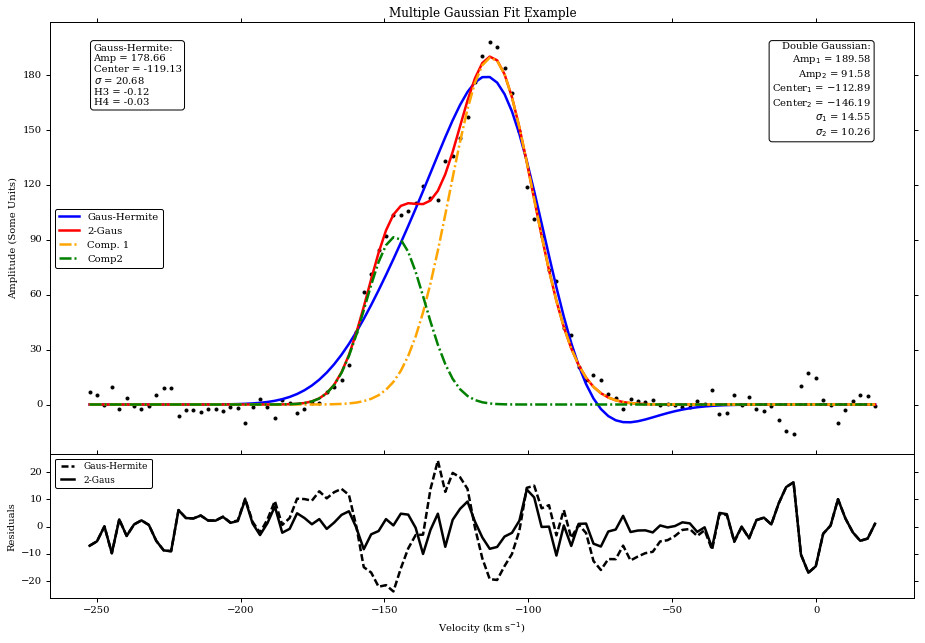

In [14]:
fig3=plt.figure(3,figsize=(15,10))
f1=fig3.add_axes((.1,.3,.8,.6))

plt.plot(vels,stackspec,'k.')
pgh,=plt.plot(vels,fit_gh,'b')
p2g,=plt.plot(vels,fit_2g,'r')
p2ga,=plt.plot(vels,gausssingle(pars_2g[0],pars_2g[1],pars_2g[2],vels),'-.',color='orange')
p2gb,=plt.plot(vels,gausssingle(pars_2g[3],pars_2g[4],pars_2g[5],vels),'-.',color='green')
f1.set_xticklabels([]) #We will plot the residuals below, so no x-ticks on this plot
plt.title('Multiple Gaussian Fit Example')
plt.ylabel('Amplitude (Some Units)')
f1.legend([pgh,p2g,p2ga,p2gb],['Gaus-Hermite','2-Gaus','Comp. 1','Comp2'],prop={'size':10},loc='center left')
 
from matplotlib.ticker import MaxNLocator
plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower')) #Removes lowest ytick label

f1.annotate('Gauss-Hermite:\nAmp = %.2f\nCenter = %.2f\n$\sigma$ = %.2f\nH3 = %.2f\nH4 = %.2f' \
    %(pars_gh[0],pars_gh[1],pars_gh[2],pars_gh[3],pars_gh[4]),xy=(.05,.95), \
    xycoords='axes fraction',ha="left", va="top", \
bbox=dict(boxstyle="round", fc='1'),fontsize=10)
f1.annotate('Double Gaussian:\nAmp$_1$ = %.2f\nAmp$_2$ = %.2f\nCenter$_1$ = %.2f\nCenter$_2$ = %.2f\n$\sigma_1$ = %.2f\n$\sigma_2$ = %.2f' \
    %(pars_2g[0],pars_2g[3],pars_2g[1],pars_2g[4],pars_2g[2],pars_2g[5]),xy=(.95,.95), \
    xycoords='axes fraction',ha="right", va="top", \
    bbox=dict(boxstyle="round", fc='1'),fontsize=10)

f2=fig3.add_axes((.1,.1,.8,.2))
 
resgh,res2g,=plt.plot(vels,resid_gh,'k--',vels,resid_2g,'k')
 
plt.ylabel('Residuals')
plt.xlabel('Velocity (km s$^{-1}$)')
f2.legend([resgh,res2g],['Gaus-Hermite','2-Gaus'],numpoints=4,prop={'size':9},loc='upper left')